In [17]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from img2vec import rgb2emb
import math
import os
import pandas as pd
import joblib

# Define the batch size
batch_size = 256

### read the data

In [2]:
train_data = pd.read_csv(os.path.join('..', '..', 'data', 'train.csv'))
val_data = pd.read_csv(os.path.join('..', '..', 'data', 'val.csv'))
test_data = pd.read_csv(os.path.join('..', '..', 'data', 'test.csv'))

### add the path of the images

In [3]:
def construct_img_path(row):
    return os.path.join("..", "..", "data", "faces", row['user_id'],
                        "coarse_tilt_aligned_face." + str(row['face_id']) + "." + row['original_image'])


train_data['img_path'] = train_data.apply(construct_img_path, axis=1)
val_data['img_path'] = val_data.apply(construct_img_path, axis=1)
test_data['img_path'] = test_data.apply(construct_img_path, axis=1)
train_data.head(5)

,user_id,face_id,original_image,age,gender,img_path
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,..\..\data\faces\9855553@N08\coarse_tilt_align...
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,..\..\data\faces\114841417@N06\coarse_tilt_ali...
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,..\..\data\faces\66870968@N06\coarse_tilt_alig...
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,..\..\data\faces\8187011@N06\coarse_tilt_align...
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,..\..\data\faces\114841417@N06\coarse_tilt_ali...


#### add column for check if the image exists
it will help us to detect if there is any missing image, or if there is any bug in the path construction

In [4]:
train_data['img_exists'] = train_data['img_path'].apply(os.path.exists)
val_data['img_exists'] = val_data['img_path'].apply(os.path.exists)
test_data['img_exists'] = test_data['img_path'].apply(os.path.exists)

train_data.head(5)

,user_id,face_id,original_image,age,gender,img_path,img_exists
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,..\..\data\faces\9855553@N08\coarse_tilt_align...,True
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,..\..\data\faces\66870968@N06\coarse_tilt_alig...,True
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,..\..\data\faces\8187011@N06\coarse_tilt_align...,True
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True


In [5]:
# Encode age labels
age_encoder = LabelEncoder()
train_data['age_label'] = age_encoder.fit_transform(train_data['age'])
val_data['age_label'] = age_encoder.transform(val_data['age'])
test_data['age_label'] = age_encoder.transform(test_data['age'])
num_classes = len(age_encoder.classes_)
print("Age classes:", age_encoder.classes_)
train_data.head(5)

Age classes: ['(0, 2)' '(15, 20)' '(25, 32)' '(38, 43)' '(4, 6)' '(48, 53)' '(60, 100)'
 '(8, 23)']


,user_id,face_id,original_image,age,gender,img_path,img_exists,age_label
0,9855553@N08,1581,11658657103_4485e3f5ac_o.jpg,"(60, 100)",m,..\..\data\faces\9855553@N08\coarse_tilt_align...,True,6
1,114841417@N06,502,12059583524_606ca96139_o.jpg,"(15, 20)",m,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True,1
2,66870968@N06,1227,11326189206_e08bdf6dfd_o.jpg,"(25, 32)",m,..\..\data\faces\66870968@N06\coarse_tilt_alig...,True,2
3,8187011@N06,988,11133041085_e2ee5e12cb_o.jpg,"(0, 2)",u,..\..\data\faces\8187011@N06\coarse_tilt_align...,True,0
4,114841417@N06,485,12059753735_7141b5443c_o.jpg,"(15, 20)",f,..\..\data\faces\114841417@N06\coarse_tilt_ali...,True,1


### Filter out any rows where the image doesn't exist

In [6]:
train_data_filtered = train_data[train_data['img_exists'] == True]
val_data_filtered = val_data[val_data['img_exists'] == True]
test_data_filtered = test_data[test_data['img_exists'] == True]

### Define a generator function to process images in batches

In [7]:
def image_batch_generator(image_paths, labels, batch_size):
    num_samples = len(image_paths)
    num_batches = math.ceil(num_samples / batch_size)

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)

        batch_paths = image_paths[start_idx:end_idx]
        batch_features = rgb2emb(batch_paths) / 255.0  # Normalize to [0,1]
        batch_labels = labels[start_idx:end_idx]

        yield batch_features, batch_labels


### Extract image paths and labels

In [8]:
train_image_paths = train_data_filtered['img_path'].tolist()
train_labels = train_data_filtered['age_label'].values

val_image_paths = val_data_filtered['img_path'].tolist()
val_labels = val_data_filtered['age_label'].values

test_image_paths = test_data_filtered['img_path'].tolist()
test_labels = test_data_filtered['age_label'].values

### Process a single batch to determine input shape

In [9]:
print("Processing a sample batch to determine input dimensions...")
sample_batch_size = min(10, len(train_image_paths))
sample_paths = train_image_paths[:sample_batch_size]
sample_batch = rgb2emb(sample_paths)
input_shape = sample_batch.shape[1]
print(f"Input shape: {input_shape}")

Processing a sample batch to determine input dimensions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Input shape: 2048


### Define the model

In [10]:
model = Sequential([
    Dense(num_classes, activation='softmax', input_shape=(input_shape,))
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

C:\Users\shayg\projects\ML\final_project\venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │        16,392 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,392 (64.03 KB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 0 (0.00 B)

### Train the model using batches

In [11]:
print("Training the model...")
epochs = 100
steps_per_epoch = math.ceil(len(train_image_paths) / batch_size)
validation_steps = math.ceil(len(val_image_paths) / batch_size)

# Custom training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    # Training
    train_loss = 0
    train_acc = 0
    batch_count = 0

    for batch_features, batch_labels in image_batch_generator(train_image_paths, train_labels, batch_size):
        # Train on batch
        batch_history = model.train_on_batch(
            batch_features,
            batch_labels,
        )

        batch_loss, batch_acc = batch_history
        train_loss += batch_loss
        train_acc += batch_acc
        batch_count += 1

        print(f"\rBatch {batch_count}/{steps_per_epoch} - loss: {batch_loss:.4f} - accuracy: {batch_acc:.4f}", end="")

    avg_train_loss = train_loss / batch_count
    avg_train_acc = train_acc / batch_count
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_acc)

    # Validation
    val_loss = 0
    val_acc = 0
    batch_count = 0

    for batch_features, batch_labels in image_batch_generator(val_image_paths, val_labels, batch_size):
        # Evaluate on batch
        batch_val_loss, batch_val_acc = model.test_on_batch(
            batch_features,
            batch_labels,
        )

        val_loss += batch_val_loss
        val_acc += batch_val_acc
        batch_count += 1

    avg_val_loss = val_loss / batch_count
    avg_val_acc = val_acc / batch_count
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_acc)

    print(
        f"\nEpoch {epoch + 1}: loss={avg_train_loss:.4f}, accuracy={avg_train_acc:.4f}, val_loss={avg_val_loss:.4f}, val_accuracy={avg_val_acc:.4f}")


Training the model...
Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 441ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 382ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 501ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 413ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 638ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 401ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 424ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 519ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 794ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 923ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 935ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 557ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 551ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 451ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 528ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 4

### Evaluate the model on test data

In [12]:
print("Evaluating the model on test data...")
test_loss = 0
test_acc = 0
batch_count = 0
all_predictions = []
all_labels = []

for batch_features, batch_labels in image_batch_generator(test_image_paths, test_labels, batch_size):
    # Evaluate on batch
    batch_test_loss, batch_test_acc = model.test_on_batch(
        batch_features,
        batch_labels,
    )

    # Get predictions for this batch
    batch_preds = model.predict_on_batch(batch_features)
    batch_pred_classes = np.argmax(batch_preds, axis=1)

    all_predictions.extend(batch_pred_classes)
    all_labels.extend(batch_labels)

    test_loss += batch_test_loss
    test_acc += batch_test_acc
    batch_count += 1

avg_test_loss = test_loss / batch_count
avg_test_acc = test_acc / batch_count
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {avg_test_acc:.4f}")


Evaluating the model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 611ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 780ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 726ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 773ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 726ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 684ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 765ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 757ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 3s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step
Test Loss: 1.4183
Test Accuracy: 0.4736


### Visualize results

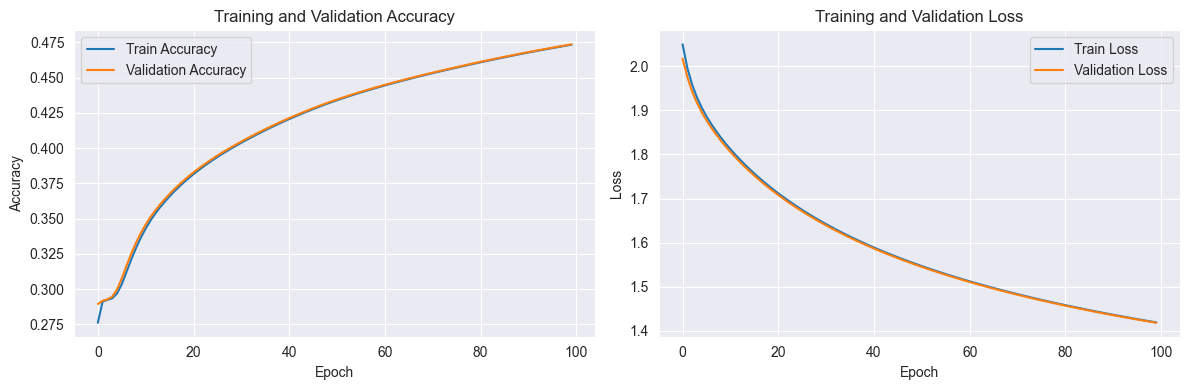

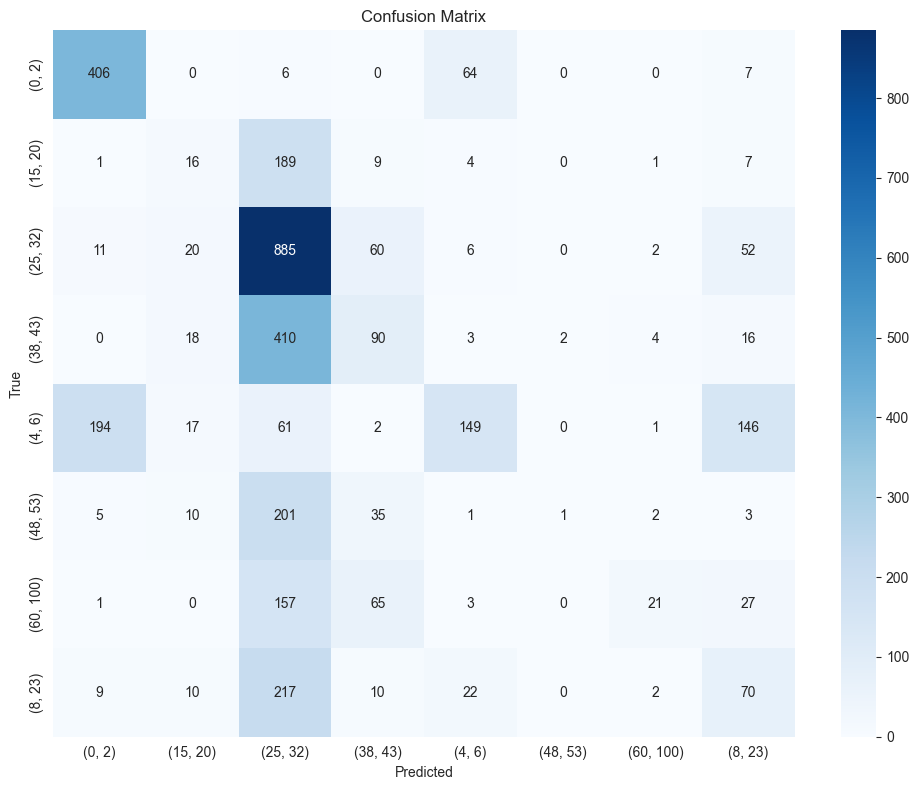

Classification Report:
              precision    recall  f1-score   support

      (0, 2)       0.65      0.84      0.73       483
    (15, 20)       0.18      0.07      0.10       227
    (25, 32)       0.42      0.85      0.56      1036
    (38, 43)       0.33      0.17      0.22       543
      (4, 6)       0.59      0.26      0.36       570
    (48, 53)       0.33      0.00      0.01       258
   (60, 100)       0.64      0.08      0.14       274
     (8, 23)       0.21      0.21      0.21       340

    accuracy                           0.44      3731
   macro avg       0.42      0.31      0.29      3731
weighted avg       0.44      0.44      0.37      3731


In [13]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=age_encoder.classes_,
            yticklabels=age_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_predictions, target_names=age_encoder.classes_))


### Save the model and LabelEncoder

In [18]:
model.save('basic_softmax_age_classifier.h5')
print("Model saved successfully.")

# Save the LabelEncoder
joblib.dump(age_encoder, 'age_encoder.pkl')
print("Age encoder saved successfully.")

Model saved successfully.
Age encoder saved successfully.


### exapmle of use

In [16]:
import joblib
import numpy as np
import tensorflow as tf
from img2vec import rgb2emb

# Load the trained model
model = tf.keras.models.load_model('basic_softmax_age_classifier.h5')
print("Model loaded successfully.")

# Load the LabelEncoder
age_encoder = joblib.load('age_encoder.pkl')
print("Age encoder loaded successfully.")


# Function to predict age range for a new image
def predict_age(image_path, model, age_encoder):
    # Extract features using rgb2flat
    features = rgb2emb([image_path])
    # Normalize features
    features = features / 255.0
    # Make prediction
    pred_probs = model.predict(features)[0]
    # Get predicted class
    pred_class = np.argmax(pred_probs)
    # Convert to age range
    pred_age_range = age_encoder.classes_[pred_class]
    confidence = pred_probs[pred_class]

    return pred_age_range, confidence

# Example usage:
image_path = "img.jpg"
pred_age, confidence = predict_age(image_path, model, age_encoder)
print(f"Predicted age range: {pred_age} with confidence {confidence:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted age range: (25, 32) with confidence 0.36
